# 各种格式地理信息数据读取和显示

常见空间数据格式包括：文本xy坐标（包括.dat, .csv, .xls, .txt）、.shp、GeoJson、图像（包括GeoTiff等）、netCDF。以上格式数据在Python中皆可处理，不过可能需要用到多个不同的工具包，本文将介绍作者所熟悉的几种除GDAL外的Python包供读者探讨。

*Macbook Pro 2011b, OSX，python3.5*

## 矢量数据类

### xy坐标，气象站点的分布

本节介绍如何使用Pandas读取及简单处理文本文件存储的点坐标，并使用基于Matplotlib的CartoPy绘制地图，力图用**最简单**的方法来解决一些常见的问题。pandas用来处理文本表格数据非常舒服，推荐Mckinney著，机械工业出版社的《利用Python进行数据分析》。
* 建议使用conda安装方式，如安装CartoPy遇见麻烦，可以通过conda-forge安装，执行代码：
    `conda install cartopy -c conda-forge`
* 如果认为Anaconda太大，很多内置的包用不上，可参考使用Miniconda，一键安装脚本可参考[Nicola的博客](http://nicolasfauchereau.github.io/climatecode/posts/miniconda-installation/)。

全国气象站点空间信息（Excel .xlsx格式，包括名称、坐标、海拔高度）可从中国气象数据网下载，[点击获取](http://image.data.cma.cn/static/doc/A/A.0012.0001/SURF_CHN_MUL_HOR_STATION.xlsx)。

In [1]:
import pandas as pd

如果用pandas读Excel文件，需要事先安装xlrd包，conda install xlrd即可

In [39]:
data = pd.read_excel('SURF_CHN_MUL_HOR_STATION.xlsx')

In [4]:
data.head()

,省份,区站号,站名,纬度,经度,气压传感器拔海高度（米）,观测场拔海高度（米）
0,安徽,58015,砀山,34.27,116.20,45.4,44.200001
1,安徽,58016,萧县,34.11,116.58,35.9,34.700001
2,安徽,58102,亳州,33.52,115.46,39.2,37.700000
3,安徽,58107,临泉,33.01,115.17,37.0,35.800000
4,安徽,58108,界首,33.14,115.20,35.0,34.000000


pandas的选择操作很灵活，在此依次展示：
1. 挑选站名为“北京”的记录
2. 省份为西藏的记录数
3. 观测场海拔高度最高的5个站

In [5]:
data.ix[data['站名']=='北京',:]

,省份,区站号,站名,纬度,经度,气压传感器拔海高度（米）,观测场拔海高度（米）
79,北京,54511,北京,39.48,116.28,32.5,31.3


In [18]:
data.ix[data['省份']=='西藏',:].shape[0]

23

如下，通过==选择得到的True/False列，True为1，False为0，所以此列之和也是所选得到的记录数目

In [19]:
(data['省份']=='西藏').sum()

23

In [24]:
data.sort_values('观测场拔海高度（米）',ascending=False).head(5)

,省份,区站号,站名,纬度,经度,气压传感器拔海高度（米）,观测场拔海高度（米）
1371,青海,52908,五道梁,35.13,93.05,4613.0,4612.2
1380,青海,56004,沱沱河,34.13,92.26,4533.9,4533.1
1869,西藏,55299,那曲,31.29,92.04,4508.2,4507.0
1386,青海,56034,清水河,33.48,97.08,4416.2,4415.4
1868,西藏,55248,改则,32.09,84.25,4416.1,4414.9


不能肯定经纬度是十进制度格式的还是度.分格式的，那么来验证一下经纬度小数点后的两位是否全都不超过60

In [36]:
data['经度'].apply(lambda x: x-int(x)).sort_values(ascending=False).head()

1560    0.59
425     0.59
1150    0.59
27      0.59
1295    0.59
Name: 经度, dtype: float64

很显然，经纬度是度.分格式存储的，为方便计算，我们将其转换成十进制度。首先定义一个计算十进制度的函数：

In [42]:
def min2deg(x):
    y = int(x)
    y = y + (x - y)*1.66666667
    return y

In [46]:
data['经度'] = data['经度'].apply(min2deg)

In [47]:
data['纬度'] = data['纬度'].apply(min2deg)

In [50]:
data[['站名','经度','纬度']].head()

,站名,经度,纬度
0,砀山,116.333333,34.450000
1,萧县,116.966667,34.183333
2,亳州,115.766667,33.866667
3,临泉,115.283333,33.016667
4,界首,115.333333,33.233333


有了点坐标，我们现在将他们绘制到地图上，需要用到Matplotlib和CartoPy，先画一个简单的中国地图，并点上所有坐标点。

In [51]:
%matplotlib inline

In [52]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

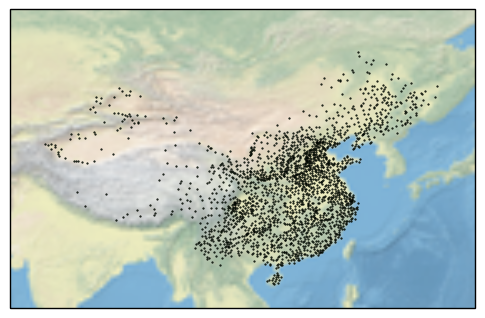

In [291]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([70, 140, 15, 55])
ax.stock_img();

ax.scatter(data['经度'],data['纬度'],s=0.3,c='g');

此外我们还可以对这些点做一定的统计分析，比如看一下海拔分布：

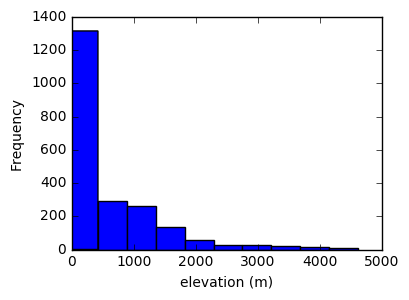

In [288]:
plt.figure(figsize=(4,3))
ax = data['气压传感器拔海高度（米）'].plot(kind='hist');
ax.set_xlim([0,5000])
plt.xlabel('elevation (m)');

### ESRI Shapefile，中亚地区国家

ESRI .shp文件可以使用Cartopy显示，空间查询可使用Shapely。在此本文使用Natural Earth的1:1000万世界国家数据[点击下载](http://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip)，演示shapefile格式数据的显示和查询。

In [156]:
import cartopy.io.shapereader as shpreader

In [157]:
reader = shpreader.Reader('ne_10m_admin_0_countries.shp')

`Reader.records()`返回的是一个生成器，可以参考函数式编程的各种方法，比如map, reduce, filter, etc.。

In [180]:
countries = reader.records()

可以用`next(countries).attributes`来查看第一个记录都有哪些属性，注意，可以把生成器的next()方法理解成一个游标，一行一行往下走，那么如果想重新循环的话就要重置一下，`countries = reader.records()`

In [181]:
c_list = [country for country in countries if country.attributes['ADMIN']=='China']
countries = reader.records()

当然，中国只有一个：

In [182]:
len(c_list)

1

看一下中亚国家有哪些。首先我们可以先封装一下函数，以便下次使用：

In [187]:
def get_record(key,value):
    countries = reader.records()
    result = [country for country in countries if country.attributes[key]==value]
    countries = reader.records()
    return result

In [204]:
cas = get_record('SUBREGION','Central Asia')

In [205]:
[r.attributes['ADMIN'] for r in cas]

['Baykonur Cosmodrome',
 'Kazakhstan',
 'Kyrgyzstan',
 'Tajikistan',
 'Turkmenistan',
 'Uzbekistan']

原来，位于哈萨克斯坦的拜科努尔航天发射场也被单独作为一条记录，我们将其删去：

In [206]:
cas.pop(0);

每一条记录都由geometry和attributes组成，将列表中所有记录的geometry循环添加到图上即可生成地图。这里我们更进一步把地名用text()函数表在图上。

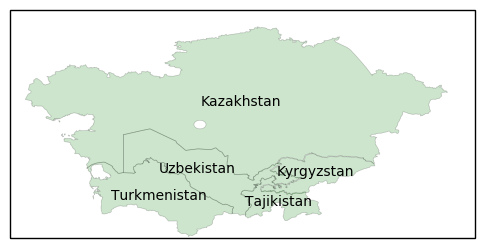

In [227]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([45,90,35,55])
for r in cas:
    ax.add_geometries(r.geometry,ccrs.PlateCarree(),
                      facecolor='green',edgecolor='black',alpha=0.2,linewidth=0.5)
    ax.text(r.geometry.centroid.x,r.geometry.centroid.y,r.attributes['ADMIN'],
            horizontalalignment='center',
            verticalalignment='center',
            transform=ccrs.Geodetic())

现在我们来比较一下中亚五国人口和经济，此外，用经纬度网格对地图修饰以方便阅读

首先需要用cm将属性值和颜色做一个对应，我们首先做一个最大最小值标准化：

$Y_i = \frac{X_i - X_{min}}{X_{max} - X_{min}}$

In [251]:
from matplotlib import cm

In [255]:
pop = [r.attributes['POP_EST'] for r in cas]

pop_min = min(pop)
pop_max = max(pop)

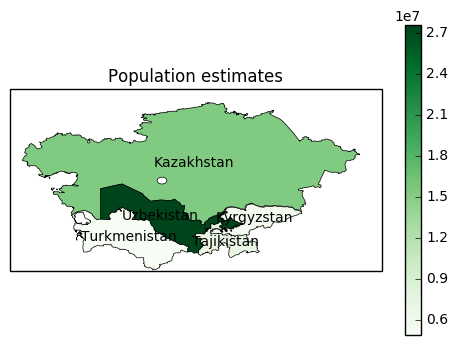

In [270]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([45,90,35,55])

for r in cas:
    
    color = cm.Greens((r.attributes['POP_EST'] - pop_min) / (pop_max - pop_min))
    
    ax.add_geometries(r.geometry,ccrs.PlateCarree(),
                      facecolor=color,edgecolor='black',linewidth=0.5)
    ax.text(r.geometry.centroid.x,r.geometry.centroid.y,r.attributes['ADMIN'],
            horizontalalignment='center',
            verticalalignment='center',
            transform=ccrs.Geodetic())
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=pop_min, vmax=pop_max))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
plt.colorbar(sm); 
plt.title('Population estimates');

看看经济情况，在加上经纬度标

In [271]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

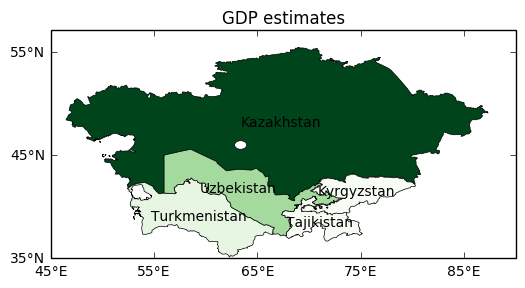

In [276]:
gdp = [r.attributes['GDP_MD_EST'] for r in cas]

gdp_min = min(gdp)
gdp_max = max(gdp)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([45,90,35,55])

for r in cas:
    
    color = cm.Greens((r.attributes['GDP_MD_EST'] - gdp_min) / (gdp_max - gdp_min))
    
    ax.add_geometries(r.geometry,ccrs.PlateCarree(),
                      facecolor=color,edgecolor='black',linewidth=0.5)
    ax.text(r.geometry.centroid.x,r.geometry.centroid.y,r.attributes['ADMIN'],
            horizontalalignment='center',
            verticalalignment='center',
            transform=ccrs.Geodetic())
    
ax.set_xticks([45,55,65,75,85], crs=ccrs.PlateCarree())
ax.set_yticks([35,45,55], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

plt.title('GDP estimates');

#### GeoJson格式

这个格式跟json没差别，使用起来只要跟shapely相互转换就行了，不过强烈建议使用[geopandas](http://geopandas.org/io.html)处理shapefile和geojson的读写，因为geopandas基于Fiona，较shapely强大。Geopandas的使用方式超出本文范围，将在随后的博文中介绍。

python4oceanographers有一个博文，提供了Shapely records和GeoJson的相互转换函数，可以[点此查看](https://ocefpaf.github.io/python4oceanographers/blog/2015/02/02/cartopy_folium_shapefile/)，文中转换geojson的主要目的是便于交互式地图Folium的显示。